In [3]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [4]:
cases = ["sq_nocut","sq_nocut2","sq_nocut3", "sq_nocut4"]
grids = ["lowest", "low", "mid", "high"]
data = []
ncs = []
for c, case in enumerate(cases):
    filepath = str(case) + "/BOUT.dmp.*.nc"

    ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
    dsn = xr.open_dataset("sq_nocut_" + str(grids[c]) + "res.fci.nc")

    # Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
    ds = ds.squeeze(drop=True)
    dsn = dsn.squeeze(drop=True)

    dx = ds["dx"].isel(z=0).values
    # Get rid of existing "x" coordinate, which is just the index values.
    #ds = ds.drop("x")
    #Create a new coordinate, which is length in units of rho_s
    ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

    data.append(ds)
    ncs.append(dsn)

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")
/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 666MB
Dimensions:             (x: 260, y: 1, z: 260, t: 201)
Coordinates:
    dx                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dy                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dz                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 2kB 0.001923 0.005769 ... 0.9942 0.9981
Data variables: (12/52)
    Bxy                 (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G1                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G2                  (x, y, z) float64 541kB dask.array

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [25]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
def make_fluid_near_ghost_mask(inside, ghost):
    """
    Return a mask for fluid cells that have at least one ghost neighbor
    in +/-x or +/-z.
    """

    # Start with no neighbors marked
    nx, nz = inside.shape

    ghost_xp = np.zeros_like(ghost, dtype=bool)
    ghost_xm = np.zeros_like(ghost, dtype=bool)
    ghost_zp = np.zeros_like(ghost, dtype=bool)
    ghost_zm = np.zeros_like(ghost, dtype=bool)

    # Shift ghost mask to find neighbors
    ghost_xp[:-1, :] = ghost[1:, :]   # neighbor at +x
    ghost_xm[1:,  :] = ghost[:-1, :]  # neighbor at -x
    ghost_zp[:, :-1] = ghost[:, 1:]   # neighbor at +z
    ghost_zm[:, 1:]  = ghost[:, :-1]  # neighbor at -z

    has_ghost_neighbor = ghost_xp | ghost_xm | ghost_zp | ghost_zm

    # We only care about FLUID cells that see a ghost
    mask_fluid_near_ghost = inside.astype(bool) & has_ghost_neighbor.astype(bool)
    return mask_fluid_near_ghost

def l2_error_near_ghost_cells(dens, dens_true, inside, ghost, V=None, t_index=-1):
    """
    L2 error of density at time t_index, restricted to fluid cells
    that have at least one ghost neighbor in x or z.
    """
    if V is None:
        V = np.ones_like(inside, dtype=float)

    mask_edge = make_fluid_near_ghost_mask(inside, ghost)
    diff = dens[t_index] - dens_true[t_index]  # (nx, nz)
    l2_edge = np.sqrt(np.nanmean(diff.where(mask_edge)**2))
    
    xsz = np.shape(dens[t_index])[0]
    zsz = np.shape(dens[t_index])[1]
    xcut = xsz//2 - 2*xsz//64
    zcut = (zsz-4)//2 - 2*(zsz-4)//64
    ctr_diff = dens[1,xcut:-xcut,zcut:-zcut] - dens_true[1,xcut:-xcut,zcut:-zcut]
    l2_ctr = np.sqrt(np.nanmean(ctr_diff**2))
    return l2_edge, mask_edge, l2_ctr

def interpolate_on_boundary(x, z, density, dens_true, xb, zb, method="linear", t_index=-1):
    """
    Interpolate numerical and true density onto boundary points.

    Parameters
    ----------
    x, z : 1D arrays
        Grid coordinates in x and z directions.
    density, dens_true : 2D arrays, shape (len(x), len(z))
        Numerical and reference ("true") fields at a fixed time.
    xb, zb : arrays of same shape
        Boundary point coordinates (x_b, z_b).
    method : {"linear", "nearest"}, optional
        Interpolation method for RegularGridInterpolator.
        ("linear" ~ bilinear in 2D)

    Returns
    -------
    dens_b : array, same shape as xb
        Interpolated numerical density at boundary.
    dens_true_b : array, same shape as xb
        Interpolated true density at boundary.
    err_b : array, same shape as xb
        Pointwise error dens_b - dens_true_b.
    """
    # Flatten boundary points to (N, 2)
    pts = np.column_stack((xb.ravel(), zb.ravel()))

    interp_num = RegularGridInterpolator(
        (x, z), density[t_index,:,:].values,
        method=method,
        bounds_error=False,
        fill_value=None,  # extrapolate if slightly outside
    )
    interp_true = RegularGridInterpolator(
        (x, z), dens_true[t_index,:,:].values,
        method=method,
        bounds_error=False,
        fill_value=None,
    )

    dens_b_flat = interp_num(pts)
    dens_true_b_flat = interp_true(pts)

    dens_b = dens_b_flat.reshape(xb.shape)
    dens_true_b = dens_true_b_flat.reshape(xb.shape)
    err_b = dens_b - dens_true_b
    
    err_flat = err_b.ravel()
    l2 = np.sqrt(np.mean(err_flat**2))
    linf = np.max(np.abs(err_flat))
    return l2,linf


In [26]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

def ib_boundary_errors_from_ghostid(
    dens_t,                 # 2D (nx,nz) at one timestep
    dens_true_t,            # Real dens for testing image points.
    ghost_id,               # 2D (nx,nz) ints: -1 or gid into *_pts arrays
    gst_pts, bdy_pts, img_pts,  # 2D (Ng,2): gst_pts are (ix,iz) indices; bdy/img are (R,Z)
    normals,                # 2D (Ng,2): (nR,nZ)
    norm_dist,              # 1D (Ng,)
    Rarr, Zarr,             # 2D (nx,nz) physical coordinates
    mask=None,              # optional 2D bool; if provided, reports stencil validity fraction
    bc_val_dir=0.0,         # constant Dirichlet value (ignored if phiB_true_fn provided)
    bc_val_neu=0.0,         # constant Neumann value (ignored if g_true_fn provided)
    phiB_true_fn=None,      # callable (R,Z)->phi_B_true for Dirichlet
    g_true_fn=None,         # callable (R,Z,nR,nZ)->dphi/dn true for Neumann
    use_norm_dist=True,     # if False, uses |I-B| computed from points
    check_equidistance=True):
    """
    Postprocess boundary errors for IB ghost-cell method using stored G,B,I pairing.

    Dirichlet:
      phi_B_hat = 0.5*(phi_G + phi_I)

    Neumann:
      g_hat = (phi_I - phi_G)/(2*d)  where d = norm_dist[gid] or |I-B|

    Returns a dict with L2/Linf metrics and some diagnostics.
    """

    dens_t = np.asarray(dens_t)
    ghost_id = np.asarray(ghost_id)

    # spline axes
    R1d = np.asarray(Rarr)[:, 0]
    Z1d = np.asarray(Zarr)[0, :]

    # bilinear spline for phi_I
    spl = RectBivariateSpline(R1d, Z1d, dens_t, kx=1, ky=1)
    spl_true = RectBivariateSpline(R1d, Z1d, dens_true_t, kx=1, ky=1)

    # find ghost grid locations and their ghost-record ids
    ii, kk = np.where(ghost_id >= 0)
    if ii.size == 0:
        return {
            "n_ghost": 0,
            "dir_l2": np.nan, "dir_linf": np.nan,
            "neu_l2": np.nan, "neu_linf": np.nan,
        }

    gid = ghost_id[ii, kk].astype(int)

    # phi_G from ghost grid cell
    phiG = dens_t[ii, kk]

    # geometry at ghost-record level
    BI = img_pts[gid]          # (R,Z)
    BB = bdy_pts[gid]          # (R,Z)
    nR = normals[gid, 0]
    nZ = normals[gid, 1]

    # phi_I from spline at image points
    phiI = spl.ev(BI[:, 0], BI[:, 1])
    phiI_true = spl_true.ev(BI[:,0], BI[:,1])

    # ---- Dirichlet error ----
    phiB_hat = 0.5 * (phiG + phiI)

    if phiB_true_fn is not None:
        phiB_true = phiB_true_fn(BB[:, 0], BB[:, 1])
    else:
        phiB_true = bc_val_dir * np.ones_like(phiB_hat)

    err_dir = phiB_hat - phiB_true
    dir_l2 = np.sqrt(np.mean(err_dir**2))
    dir_linf = np.max(np.abs(err_dir))

    # ---- Neumann error ----
    if use_norm_dist:
        d = np.asarray(norm_dist)[gid].astype(float)
    else:
        d = np.sqrt((BI[:, 0] - BB[:, 0])**2 + (BI[:, 1] - BB[:, 1])**2)

    d = np.where(d > 0, d, np.nan)
    g_hat = (phiI - phiG) / (2.0 * d)

    if g_true_fn is not None:
        g_true = g_true_fn(BB[:, 0], BB[:, 1], nR, nZ)
    else:
        g_true = bc_val_neu * np.ones_like(g_hat)

    err_neu = g_hat - g_true
    neu_l2 = np.sqrt(np.nanmean(err_neu**2))
    neu_linf = np.nanmax(np.abs(err_neu))

    err_img = phiI - phiI_true
    img_l2 = np.sqrt(np.nanmean(err_img**2))
    img_linf = np.nanmax(np.abs(err_img))

    out = {
        "n_ghost": int(ii.size),
        "dir_l2": float(dir_l2),
        "dir_linf": float(dir_linf),
        "neu_l2": float(neu_l2),
        "neu_linf": float(neu_linf),
        "img_l2": float(img_l2),
        "img_linf": float(img_linf)
    }

    # ---- Optional diagnostics ----
    if check_equidistance:
        # Map gst_pts[gid]=(ix,iz) to physical (R,Z)
        gix = np.asarray(gst_pts)[gid, 0].astype(int)
        giz = np.asarray(gst_pts)[gid, 1].astype(int)
        nx, nz = dens_t.shape
        gix = np.clip(gix, 0, nx - 1)
        giz = np.clip(giz, 0, nz - 1)

        RG = np.asarray(Rarr)[gix, giz]
        ZG = np.asarray(Zarr)[gix, giz]

        d_BG = np.sqrt((RG - BB[:, 0])**2 + (ZG - BB[:, 1])**2)
        d_BI = np.sqrt((BI[:, 0] - BB[:, 0])**2 + (BI[:, 1] - BB[:, 1])**2)
        ratio = d_BG / np.where(d_BI > 0, d_BI, np.nan)

        out.update({
            "eq_max_abs_ratio_minus_1": float(np.nanmax(np.abs(ratio - 1.0))),
            "eq_mean_abs_ratio_minus_1": float(np.nanmean(np.abs(ratio - 1.0))),
        })

    if mask is not None:
        # Fraction of image-point bilinear stencils fully within "valid" mask
        valid = np.asarray(mask).astype(bool)
        iL = np.searchsorted(R1d, BI[:, 0], side="right") - 1
        kL = np.searchsorted(Z1d, BI[:, 1], side="right") - 1
        iL = np.clip(iL, 0, len(R1d) - 2)
        kL = np.clip(kL, 0, len(Z1d) - 2)
        stencil_ok = (
            valid[iL,   kL] &
            valid[iL+1, kL] &
            valid[iL,   kL+1] &
            valid[iL+1, kL+1]
        )
        out["image_stencil_valid_frac"] = float(np.mean(stencil_ok))

    return out

In [ ]:
Lbs = np.array([1.75, 1.75, 1.75, 1.75])
Rbs = np.array([3.25, 3.25, 3.25, 3.25])
Bbs = np.array([-0.7720588235294118, -0.7613636363636364, -0.7557692307692307, -0.75290698])
Tbs = -Bbs

D = 1.0
m = 1.0
n = 1.0
bc_val = 0.0
timestep_for_errs_early = 10
timestep_for_errs_late = 100

w_unit = 95788333.030660808 #Omega_ci
t_unit = 1/w_unit

denses = []
dens_trues = []
srcs = []
masks = []
ghost_masks = []
dens_diffs = []
num_errs = []
l2_errs = []
linf_errs = []

lbda_errs = np.zeros_like(Lbs)
l2_bd_err = []
linf_bd_err = []
l2_imgs = []
linf_imgs = []
l2_edges = []
l2_inner_errs = []
mass_changes = []
mass_errs = []

for d, dat in enumerate(data):
    print("Reading data for run: ", d)
    dens = dat["Nh+"]
    src = dat["SNh+"]
    dens_true = dens.copy()

    mask = ncs[d]["in_mask"]
    #vols = ncs[d]["vol_frac"]
    ghost_id = ncs[d]["ghost_id"].values
    ghost_mask = (ghost_id >= 0).astype(bool)
    full_mask = ghost_mask | mask.astype(bool)
    #vols = np.where(mask, vols, 0)
    gst_pts = ncs[d]["ghost_pts"].values
    bdy_pts = ncs[d]["bndry_pts"].values
    img_pts = ncs[d]["image_pts"].values
    normals = ncs[d]["normals"].values
    norm_dist = ncs[d]["norm_dist"].values
    is_plasma = ncs[d]["is_plasma"].values
    Rarr = ncs[d]["R"].values
    Zarr = ncs[d]["Z"].values

    
    spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
    spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:],  kx=1, ky=1)
    nx = 64*(2**(d))
    nz = nx + 4
    dx = np.float64(1.0) / np.float64(nx)
    dz = np.float64(1.0) / np.float64(nz)

    # Centers in x; faces/nodes in z if that's your convention
    x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
    z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

    ghosts_lo_x = x[0]  - dx*np.arange(2, 0, -1)
    ghosts_hi_x = x[-1] + dx*np.arange(1, 2+1)
    x = np.concatenate((ghosts_lo_x, x, ghosts_hi_x))
    xx,zz = np.meshgrid(x,z,indexing='ij')

    Lb, Rb, Bb, Tb = Lbs[d], Rbs[d], Bbs[d], Tbs[d]

    #Use physical grid values to map R,Z boundary to x,z (i.e. ignore ghosts)
    R_min, R_max = ncs[d]["R"].values[2,0], ncs[d]["R"].values[-3,0]
    Z_min, Z_max = ncs[d]["Z"].values[0,0], ncs[d]["Z"].values[0,-1]
    dR = ncs[d]["R"].values[1,0] - ncs[d]["R"].values[0,0]
    dZ = ncs[d]["Z"].values[0,1] - ncs[d]["Z"].values[0,0]
    xL = x[2] + (Lb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
    xR = x[2] + (Rb - R_min) * (x[-3] - x[2]) / (R_max - R_min)
    zB = z[0] + (Bb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)
    zT = z[0] + (Tb - Z_min) * (z[-1] - z[0]) / (Z_max - Z_min)

    Lx = xR - xL
    Lz = zT - zB
    xi   = (x - xL)/ Lx
    zeta = (z - zB)/ Lz
    lbda = (m*np.pi/(Rb-Lb))**2 + (n*np.pi/(Tb-Bb))**2

    xxi, zzeta = np.meshgrid(xi,zeta,indexing='ij',copy=False)
    t64 = np.asarray(dat["t_array"].values, dtype=np.float64) # 1D time
    t_norm = t64*t_unit

    print("left, right: ", xL, zB)
    print("Box size: ", Lx, Lz)

    #Compare simulation lambda to analytic value:
    #Use density near the center, which is always 1...
    n0 = dens.values[0,(nx+4)//2-1,nz//2-1]
    n1 = dens.values[1,(nx+4)//2-1,nz//2-1]
    dt = t_norm[1] - t_norm[0]
    ratio = (n1 - bc_val) / (n0 - bc_val)
    lambda_eff = -np.log(ratio) / (D * dt)
    #print("Effective lambda from simulation after one timestep:", lambda_eff)
    #print("Analytic lambda:", lbda)
    lbda_errs[d] = 100*np.abs((lambda_eff - lbda))/lbda
    #print("Percent error:", lbda_errs[d])

    spatial = np.cos(m * np.pi * xxi) * np.cos(n * np.pi * zzeta)
    temp = np.exp(-D * lbda * t_norm)

    dens_true[:,:,:] = bc_val + np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

    denses.append(dens)
    dens_trues.append(dens_true)
    srcs.append(src)
    masks.append(mask)
    ghost_masks.append(ghost_mask)

    #l2_err_b, linf_err_b = interpolate_on_boundary(
    #    Rarr[:,0], Zarr[0,:], dens, dens_true, bdy_pts[:,0], bdy_pts[:,1], method="linear",
    #    t_index = timestep_for_errs_early)
    metrics = ib_boundary_errors_from_ghostid(
        dens_t=dens.values[1, :, :],
        dens_true_t = dens_true.values[1,:,:],
        ghost_id=ghost_id,
        gst_pts=gst_pts,
        bdy_pts=bdy_pts,
        img_pts=img_pts,
        normals=normals,
        norm_dist=norm_dist,
        Rarr=Rarr,
        Zarr=Zarr,
        mask=mask,   # optional
        bc_val_dir=bc_val,
        bc_val_neu=bc_val)
    l2_err_b, linf_err_b = metrics["neu_l2"], metrics["neu_linf"]
    l2_img, linf_img = metrics["img_l2"], metrics["img_linf"]
    l2_bd_err.append(l2_err_b)
    linf_bd_err.append(linf_err_b)
    l2_imgs.append(l2_img)
    linf_imgs.append(linf_img)

    M0 = (dens.where(mask)*dR*dZ)[0,:,:].sum().values
    M1 = (dens.where(mask)*dR*dZ)[10,:,:].sum().values
    M2 = (dens.where(mask)*dR*dZ)[100,:,:].sum().values
    M3 = (dens.where(mask)*dR*dZ)[-1,:,:].sum().values
    #M0 = (dens.where(mask)*vols*dR*dZ)[0,:,:].sum().values
    #M1 = (dens.where(mask)*vols*dR*dZ)[10,:,:].sum().values
    #M2 = (dens.where(mask)*vols*dR*dZ)[100,:,:].sum().values
    #M3 = (dens.where(mask)*vols*dR*dZ)[-1,:,:].sum().values
    print("Mass over time: ", M0, M1, M2, M3)
    mass_change = M3-M0
    mass_changes.append(mass_change)
    mass_errs.append(np.abs(mass_change)/M0)

    #Get L2 error
    N_valid = np.sum(mask)
    dens_diff = np.abs(dens.where(mask)-dens_true.where(mask))
    linf_err_t = np.max(dens_diff)
    l2_err_t = np.sqrt(np.sum((dens_diff**2), axis=(1, 2)) / N_valid)
    dens_diffs.append(dens_diff)
    l2_errs.append(l2_err_t.values)
    linf_errs.append(linf_err_t.values)

    init_dens_diff = dens_diff[0,:,:]
    mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
    nerrs = int(mask2.sum().compute())
    num_errs.append(nerrs)
    
    #L2 error on ghost cells.
    L2_edge, edge_mask, l2_inner_err = l2_error_near_ghost_cells(dens, dens_true, mask, ghost_mask, V=dR*dZ, t_index=1)
    l2_edges.append(L2_edge)
    l2_inner_errs.append(l2_inner_err)

print('\n')
print("Eigenmode rel. err.: ", lbda_errs[0], lbda_errs[1], lbda_errs[2], lbda_errs[3])
print("Eigenmode rel. err. convergence: ", lbda_errs[0]/lbda_errs[1], lbda_errs[1]/lbda_errs[2], lbda_errs[2]/lbda_errs[3])

print('\n')
print("Mass change: ", mass_changes[0], mass_changes[1], mass_changes[2], mass_changes[3])
print("Mass errs: ", mass_errs[0], mass_errs[1], mass_errs[2], mass_errs[3])

print('\n')
print("L2 Bdy Err: ", l2_bd_err[0], l2_bd_err[1], l2_bd_err[2], l2_bd_err[3])
print("L2 Bdy Err convergence: ", l2_bd_err[0]/l2_bd_err[1], l2_bd_err[1]/l2_bd_err[2], l2_bd_err[2]/l2_bd_err[3])

print('\n')
print("Linf Bdy Err: ", linf_bd_err[0], linf_bd_err[1], linf_bd_err[2], linf_bd_err[3])
print("Linf Bdy Err. convergence: ", linf_bd_err[0]/linf_bd_err[1], linf_bd_err[1]/linf_bd_err[2], linf_bd_err[2]/linf_bd_err[3])

print('\n')
print("L2 img error: ", l2_imgs[0], l2_imgs[1], l2_imgs[2], l2_imgs[3])
print("L2 img err convergence: ", l2_imgs[0]/l2_imgs[1], l2_imgs[1]/l2_imgs[2], l2_imgs[2]/l2_imgs[3])

print('\n')
print("L2 early innermost error: ", l2_inner_errs[0], l2_inner_errs[1], l2_inner_errs[2], l2_inner_errs[3])
print("L2 convergence in early innermost cells: ", l2_inner_errs[0]/l2_inner_errs[1], l2_inner_errs[1]/l2_inner_errs[2], l2_inner_errs[2]/l2_inner_errs[3])

print('\n')
print("L2 relative error in fluid cells touching ghosts: ", l2_edges[0], l2_edges[1], l2_edges[2], l2_edges[3])
print("L2 convergence in fluid cells touching ghosts: ", l2_edges[0]/l2_edges[1], l2_edges[1]/l2_edges[2], l2_edges[2]/l2_edges[3])

print('\n')
print("Cells different than analytic initial value: ", num_errs[0], num_errs[1], num_errs[2], num_errs[3])

print('\n')
print("Linf errs: ", linf_errs[0], linf_errs[1], linf_errs[2], linf_errs[3])
print("Linf convergence: ", linf_errs[0]/linf_errs[1], linf_errs[1]/linf_errs[2], linf_errs[2]/linf_errs[3])

print('\n')
print("L2 max errs: ", np.max(l2_errs[0]), np.max(l2_errs[1]), np.max(l2_errs[2]), np.max(l2_errs[3]))
print("L2 early errs: ", l2_errs[0][timestep_for_errs_early], l2_errs[1][timestep_for_errs_early], l2_errs[2][timestep_for_errs_early],
      l2_errs[3][timestep_for_errs_early])
print("L2 late errs: ", l2_errs[0][timestep_for_errs_late], l2_errs[1][timestep_for_errs_late], l2_errs[2][timestep_for_errs_late],
      l2_errs[3][timestep_for_errs_late])
print("L2 final errs: ", l2_errs[0][-1], l2_errs[1][-1], l2_errs[2][-1], l2_errs[3][-1])
print("L2 max convergence: ", np.max(l2_errs[0])/np.max(l2_errs[1]), np.max(l2_errs[1])/np.max(l2_errs[2]), np.max(l2_errs[2])/np.max(l2_errs[3]))

Reading data for run:  0
left, right:  0.25 0.24264705882352935
Box size:  0.5 0.5147058823529411
Mass over time:  0.0 3.885780586188048e-16 1.0955862952966022e-15 1.1088550664153408e-15
Reading data for run:  1
left, right:  0.25 0.2462121212121212
Box size:  0.5 0.5075757575757573
Mass over time:  0.0 -4.67020085798131e-16 3.669635565740643e-15 -5.626360677587509e-14
Reading data for run:  2
left, right:  0.25 0.24807692307692308
Box size:  0.5 0.5038461538461538
Mass over time:  3.469446951953614e-18 5.958775139980332e-16 5.890951517827786e-15 5.9065052662008615e-15
Reading data for run:  3
left, right:  0.25 0.24903100666666667
Box size:  0.5 0.5019379866666668
Mass over time:  -4.607859233063394e-18 2.7945310995813877e-16 4.1441256351006095e-16 4.167656739770926e-16


Eigenmode rel. err.:  0.07259429812486484 0.01920790936624073 0.004903897022731839 0.0012264360332314079
Eigenmode rel. err. convergence:  3.7793961196242676 3.9168663773327936 3.998493920478734


Mass change:  1.108

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


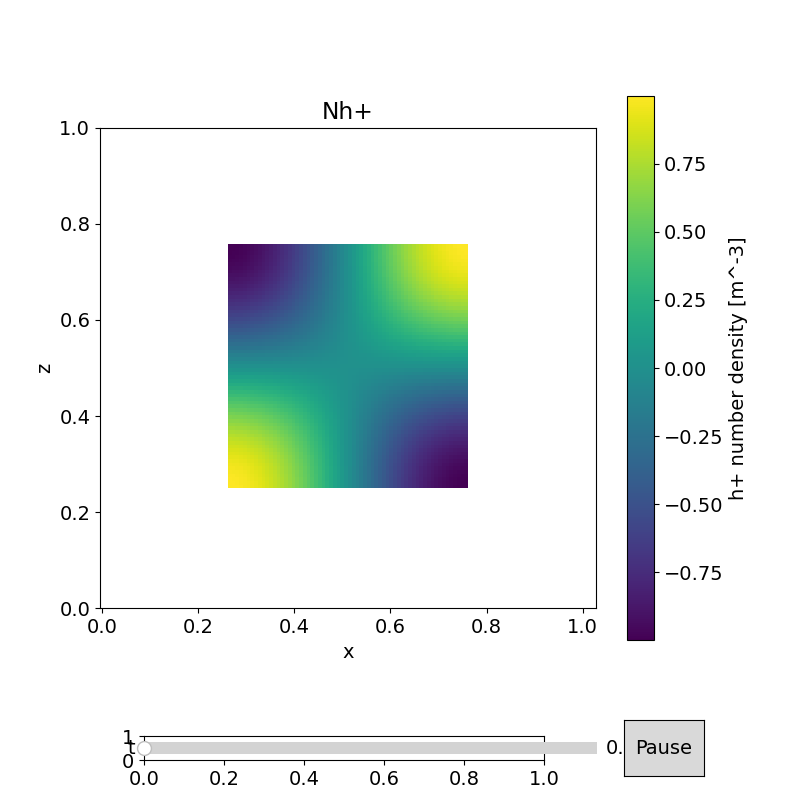

In [29]:
case_num = 1
denses[case_num].where(masks[case_num]).bout.animate2D(aspect='equal')